### W207 Final Project - Forest Coverage Classification

#### Team members: Emily, Mohan, Stefania

The project and data is from https://www.kaggle.com/c/forest-cover-type-prediction/overview

We chose to use the K-Nearest Neighbors Classifier for the baseline.

## Introduction

For our final project we set out to create a model that could predict the forest cover type based on a dataset of cartographic variables. The datasets and full project description can be found on Kaggle (https://www.kaggle.com/c/forest-cover-type-prediction/overview). In order to find the best model, we followed these steps:
1. Download and clean up data
2. Create a baseline model to compare future iterations against
3. Perform exploratory data analysis on key variables
4. Pre-process data
5. Feature engineering
6. Test various models



In [1]:
#import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn import preprocessing 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer 

# https://machinelearningmastery.com/how-to-fix-futurewarning-messages-in-scikit-learn/
# import warnings filter

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

## Download and separate data

In [59]:
# Read the data

df = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

# Rename columns
df.columns = ["Id", "Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm", "Horizontal_Distance_To_Fire_Points",
    "Wilderness_Area1", "Wilderness_Area2", "Wilderness_Area3", "Wilderness_Area4",
    "Soil_Type1",  "Soil_Type2",  "Soil_Type3",  "Soil_Type4",  "Soil_Type5",  "Soil_Type6",
    "Soil_Type7",  "Soil_Type8",  "Soil_Type9",  "Soil_Type10", "Soil_Type11", "Soil_Type12",
    "Soil_Type13", "Soil_Type14", "Soil_Type15", "Soil_Type16", "Soil_Type17",
    "Soil_Type18", "Soil_Type19", "Soil_Type20", "Soil_Type21", "Soil_Type22",
    "Soil_Type23", "Soil_Type24", "Soil_Type25", "Soil_Type26", "Soil_Type27",
    "Soil_Type28", "Soil_Type29", "Soil_Type30", "Soil_Type31", "Soil_Type32",
    "Soil_Type33", "Soil_Type34", "Soil_Type35", "Soil_Type36", "Soil_Type37",
    "Soil_Type38", "Soil_Type39", "Soil_Type40", "Cover_Type"]


In [60]:
# Seperating features (X) and labels (y)
from sklearn.model_selection import train_test_split

df = df.drop(["Id"], axis = 1)
test_data = test_data.drop(["Id"], axis = 1)

X, y = df.drop(["Cover_Type"], axis = 1), df["Cover_Type"]

train_data, dev_data, train_data_label, dev_data_label = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)
print('train_data shape: ',train_data.shape)
print('train_data_labels shape: ',train_data_label.shape)
print('dev_data shape: ',dev_data.shape)
print('dev_data_labels shape: ',dev_data_label.shape)

train_data shape:  (12096, 54)
train_data_labels shape:  (12096,)
dev_data shape:  (3024, 54)
dev_data_labels shape:  (3024,)


In [61]:
train_data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
14128,2942,151,27,376,191,1928,242,227,96,837,...,0,0,0,0,0,0,0,0,0,0
4425,2869,299,9,90,-11,1670,196,237,181,1460,...,0,0,0,0,0,0,0,0,0,0
909,2928,294,6,216,21,5075,204,239,174,1744,...,0,0,0,0,0,0,0,0,0,0
5123,2827,144,18,120,24,2255,242,234,114,1181,...,0,0,0,0,0,0,0,0,0,0
10901,2559,336,14,30,12,2006,187,220,171,524,...,0,0,0,0,0,0,0,0,0,0


## Baseline

For our baseline, we decided to use a simple KNN model. We iterated through a few values of K neighbors and found that the F1 value of the model dropped as K increased. 

Text(0.5, 1.0, 'K value vs F1 Score')

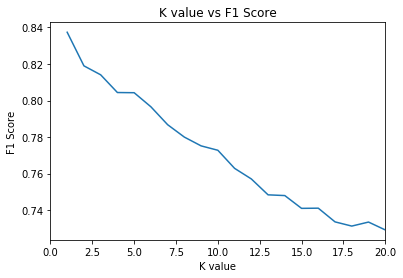

In [5]:
#create a KNN model with varying nearest neighbors as the baseline
#We chose to loop through values from 1 to 20 to assess the F1 scores the KNN algorithm
f1 = []
for i in range(1,21):
    knn_model = KNeighborsClassifier(n_neighbors = i)
    knn_model.fit(train_data, train_data_label)
    y_dev_pred = knn_model.predict(dev_data)
    knn_f1 = round(metrics.f1_score(dev_data_label, y_dev_pred, average='macro'),4)
    f1.append(knn_f1)
    #if (i == 1 or i % 2 == 0):
        #print("k = ", i, "F1 of baseline model = " + str(knn_f1))
        #print("")
        
plt.plot(range(1,21), f1)
plt.xlim(0,20)
plt.xlabel("K value")
plt.ylabel("F1 Score")
plt.title("K value vs F1 Score")

We can see that the F1 scores decline as K increases. We will use the baseline value of k = 1. The f1 score is .8374.

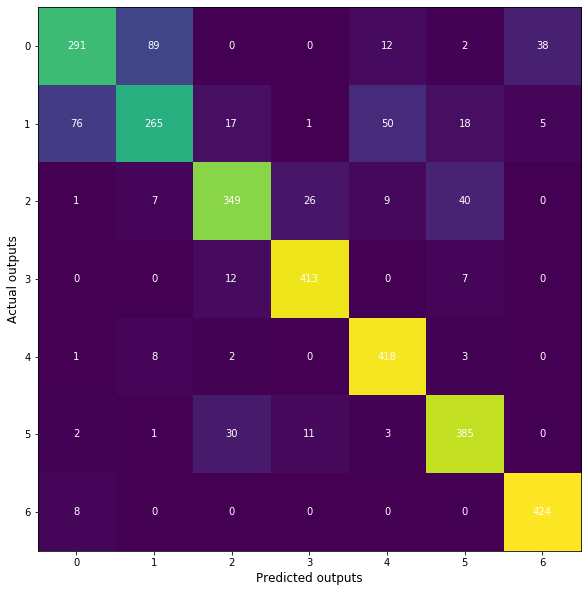

In [131]:
from sklearn.metrics import confusion_matrix
knn_model = KNeighborsClassifier(n_neighbors = 1)
knn_model.fit(train_data, train_data_label)
y_pred_label = knn_model.predict(dev_data)
y_pred_prob = knn_model.predict_proba(dev_data)

dev_data_label_list = list(dev_data_label)
        
cm = confusion_matrix(dev_data_label, y_pred_label)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=12, color='black')
ax.set_ylabel('Actual outputs', fontsize=12, color='black')
ax.xaxis.set(ticks=range(7))
ax.yaxis.set(ticks=range(7))
ax.set_ylim(6.5, -0.5)
for i in range(7):
    for j in range(7):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()



The baseline model seems to confuse mostly 1s and 2s with each other, i.e. it is having a hard time correctly classifying between cover type 1 (spruce/fir) and 2 (lodgepole pine). 

## EDA

There are twelve distinct features available to us:

1. **Elevation** - Elevation in meters 
2. **Aspect** - Aspect in degrees azimuth 
3. **Slope** - Slope in degrees 
4. **Horizontal_Distance_To_Hydrology** - Horzontal distance to nearest surface water features 
5. **Vertical_Distance_To_Hydrology** - Vertical distance to nearest surface water features 
6. **Horizontal_Distance_To_Roadways** - Horzontal distance to nearest roadway 
7. **Hillshade_9am (0 to 255 index)** - Hillshade distance at 9am, summer solstice 
8. **Hillshade_Noon (0 to 255 index)** - Hillshade index at noon, summer solstice 
9. **Hillshade_3pm (0 to 255 index)** - Hillshade index at 3pm, summer solstice 
10. **Horizontal_Distance_To_Fire_Points** - Horzontal distance to nearest wildfire ignition points 
11. **Wilderness_Area** (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation 
12. **Soil_Type** (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation 

Target is **Cover_Type** that designates forest cover type. The 7 cover types are:

1. Spruce/Fir
2. Lodgepole Pine
3. Ponderosa Pine
4. Cottonwood/Willow
5. Aspen
6. Douglas-fir
7. Krummholz

Look at the differences in Cover Type for a few of the features

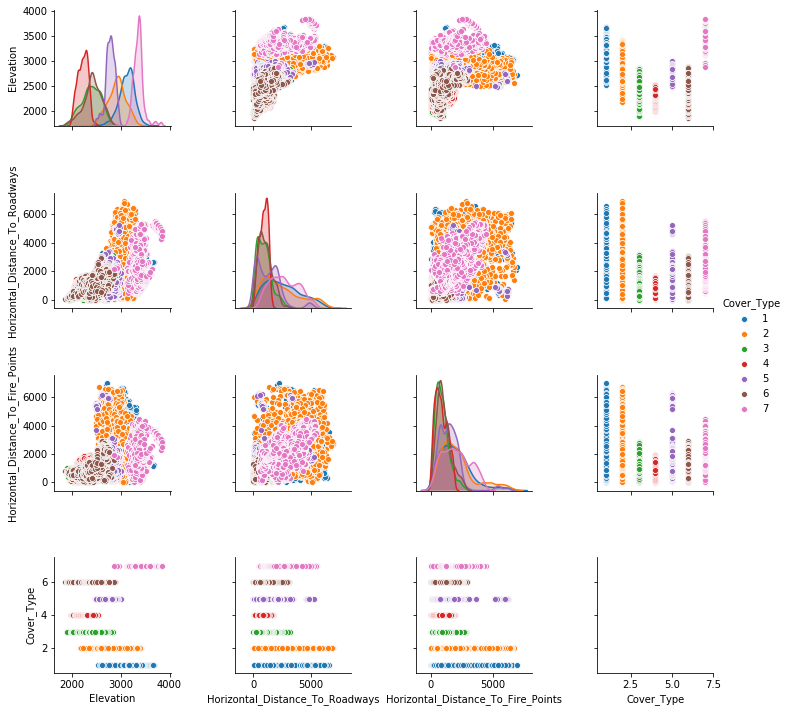

In [14]:
ex = df[["Elevation", "Horizontal_Distance_To_Roadways", "Horizontal_Distance_To_Fire_Points", "Cover_Type"]]

sns.pairplot(ex, hue = "Cover_Type")



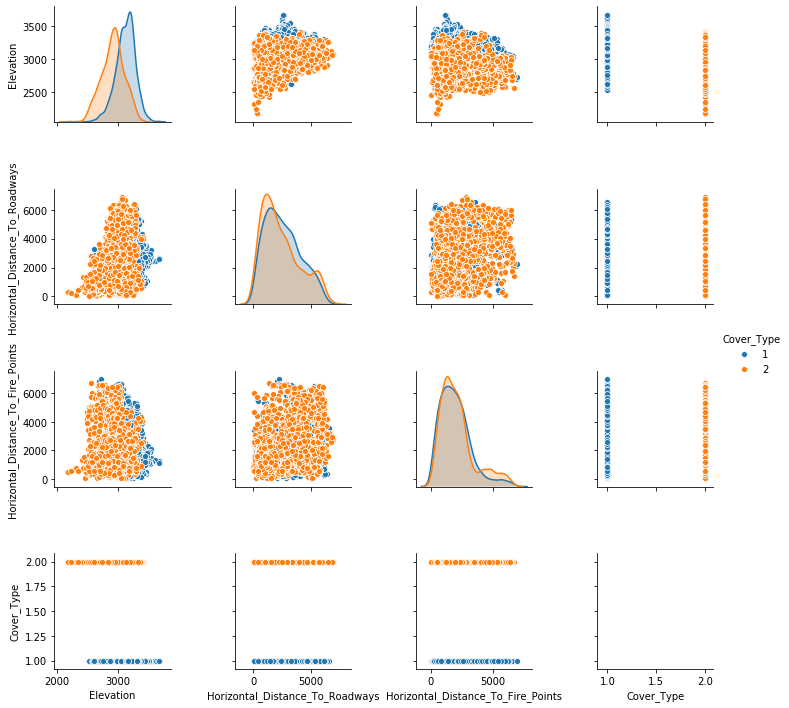

In [18]:
#Filter for cover types 1 and 2 only
def only_1_2(df1):
    limited_df = df1[(df1["Cover_Type"] == 1) | (df1["Cover_Type"] == 2)]
    return limited_df

ex_1_2 = only_1_2(ex)
sns.pairplot(ex_1_2, hue = "Cover_Type")


It's no surprise that the model confuses Types 1 and 2, since they seem very similar along these four features.

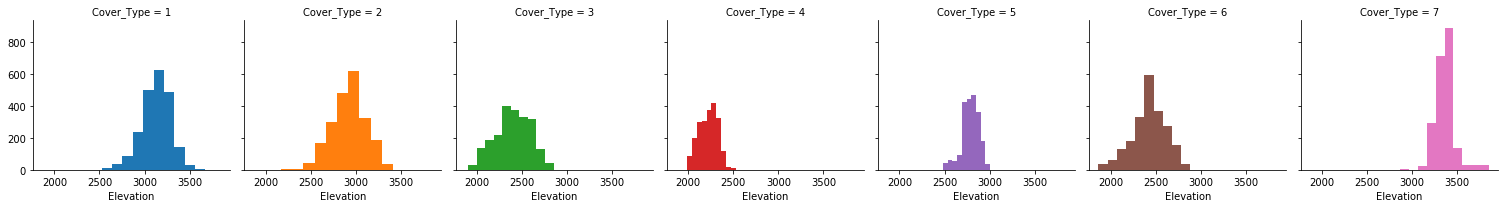

In [8]:
g = sns.FacetGrid(df, col="Cover_Type", hue = "Cover_Type")
g.map(plt.hist, "Elevation");

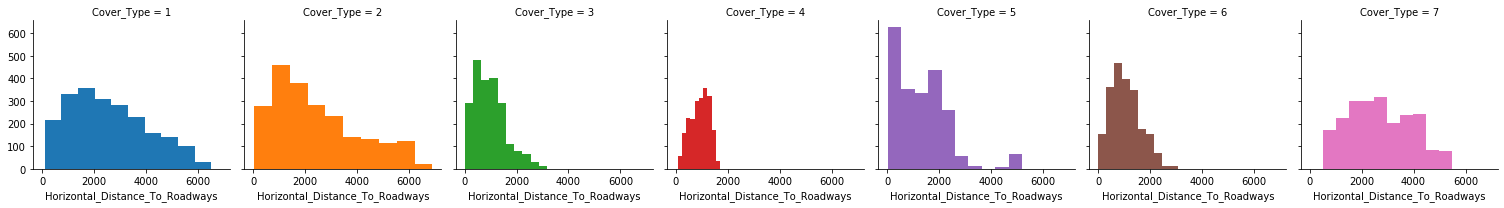

In [9]:
g = sns.FacetGrid(df, col="Cover_Type", hue = "Cover_Type")
g.map(plt.hist, "Horizontal_Distance_To_Roadways");

In [70]:
# Distribution of cover type - there is an equal dispersion of cover types throughout the data.

print("Full Dataframe: ")
print(df[["Cover_Type", "Elevation"]].groupby("Cover_Type").count())

Full Dataframe: 
            Elevation
Cover_Type           
1                2160
2                2160
3                2160
4                2160
5                2160
6                2160
7                2160


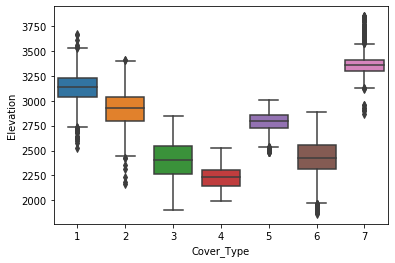

In [11]:
sns.boxplot(x=df['Cover_Type'], y=df["Elevation"], data=df)

### Soil type distribution

Soil type is represented as a binary feature in the data set There are 40 different features for each soil type.

Text(0, 0.5, 'Count')

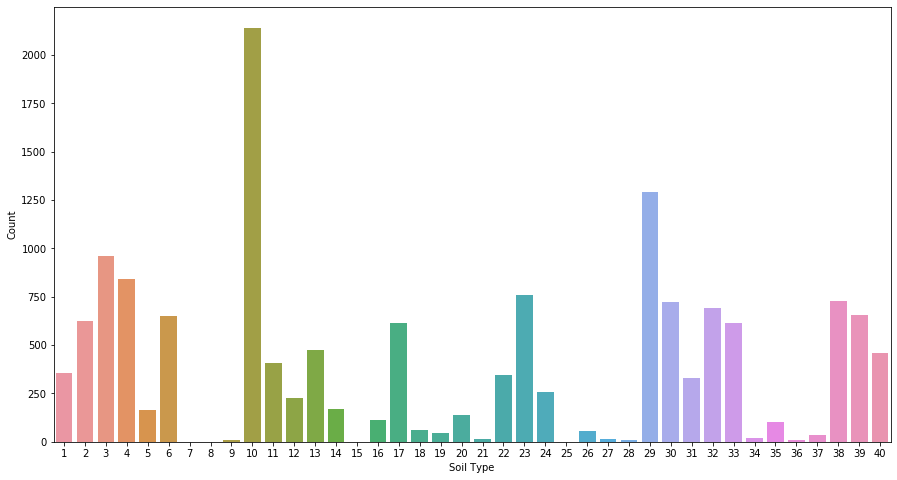

In [19]:
soil_df = df.loc[:,'Soil_Type1':'Soil_Type40']
soil_df.columns = range(1,41)
soil_series = soil_df.sum()

fig = plt.figure(figsize=(15, 8))

sns.barplot(x = soil_df.columns, y = soil_series)
plt.xlabel("Soil Type")
plt.ylabel("Count")

## Data Cleaning

Let us remove ID since this has no significance in predicting cover type. Similarly, we remove soil types 7 and 15 as these have no values represented in data.

In [62]:
#Cleaning data by removing Id, Soil_Type7 and Soil_Type15

train_data = train_data.drop(["Soil_Type7", "Soil_Type15"], axis = 1)
dev_data = dev_data.drop(["Soil_Type7", "Soil_Type15"], axis = 1)
test_data = test_data.drop(["Soil_Type7", "Soil_Type15"], axis = 1)



### Pre-processing Data

We used the Scikit-learn `Pipeline` class that applies a list of transformations to the data. We applied SimpleImputer, which replaces missing and `NAN` values with the `Median`, and a `StandardScaler` step, which subtracts the mean from each of the features and scales to unit variance. 

### Normalize data

In [37]:
#normalize all values (subtract mean, divide by standard deviation) for non-categorical features


def normalize_processor(df):
    column_trans = ColumnTransformer(
    [('scaler', StandardScaler(),["Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm", "Horizontal_Distance_To_Fire_Points"])], remainder = "passthrough") 

    dfnorm = column_trans.fit_transform(df)
    dfnorm2 = pd.DataFrame(dfnorm, columns = df.columns)
    return dfnorm2


### Condense binary columns

In [58]:
df.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

In [39]:
def rem_binary(df):
    
    wild_cols = df.loc[:, "Wilderness_Area1":"Wilderness_Area4"]

    soil_cols = df.loc[:, "Soil_Type1":"Soil_Type40"]

    def soil_factorize(row): 
        for x in soil_cols.columns:
            if row[x] == 1:
                return int(x.split("e")[1])

    df["Soil_Type"] = soil_cols.apply(soil_factorize, axis =1)

    def wild_factorize(row): 
        for x in wild_cols.columns:
            if row[x] == 1:
                return int(x.split("Area")[1])

    df["Wilderness_Area"] = wild_cols.apply(wild_factorize, axis =1)
    
    df = df.drop(['Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6',  'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40', 'Wilderness_Area1', 'Wilderness_Area2',
                  'Wilderness_Area3', 'Wilderness_Area4', 'Hillshade_3pm'], axis = 1)
    return df

### Feature Engineering 

We attempt to reduce complexity by creating features by combining existing ones to  optimize our model’s performance. In order to make the best possible prediction we need to make the most of the features we are given. This involves combining two or more significant features, or categorizing different ones to make them more digestable for the model. 

2.  **Soil Type** – We observed in the Random Forest model that soil types were individually not very important features. So we decided to aggregate these soil types to create three new features based on their textures: `soil_stony`, `soil_rubbly`, and `soil_other`
<br/><br/>
3. **Hillshade Mean** - We are given the Hillshade index at 9:00 am, noon, and 3:00 pm. Given this information, and the fact that our prior model gave importance to these features, we added another feature `Hillshade_mean`, which represents the average of these three indices.
<br/><br/>
$$ HillshadeMean = \frac{Hillshade9am + Hillshade3pm + HillshadeNoon}{3} $$


<br/><br/>

The data cleaning, feature selection, preprocessing steps, and the feature engineering are all performed in the function `feat_eng`. This will be run on both the training and testing data, to make sure the data are in sync.

In [25]:
def feat_eng(df):
    # Adding Hillshade_Mean Feature
    df['Hillshade_Mean'] =  (df['Hillshade_9am'] + df['Hillshade_Noon']  + df['Hillshade_3pm']) / 3
    
    # Adding Euclidian Distance
    
    #df['Euclidean_Dist_To_Hydrology'] =  np.sqrt(df['Horizontal_Distance_To_Hydrology'] **2 + df['Vertical_Distance_To_Hydrology'] **2 )
   # df['Euclidean_Dist_To_Hydrology'] =  np.sqrt((df['Horizontal_Distance_To_Hydrology']**2+df['Vertical_Distance_To_Hydrology']**2))
    
    # Categorizing Soil Types by texture
    stony_col = ['Soil_Type1', 'Soil_Type2', 'Soil_Type6', 'Soil_Type9', 'Soil_Type12', 'Soil_Type18', 'Soil_Type22', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']
    rubbly_col = ['Soil_Type3','Soil_Type4', 'Soil_Type5', 'Soil_Type10', 'Soil_Type11', 'Soil_Type13']
    other_col = ['Soil_Type8', 'Soil_Type14', 'Soil_Type16', 'Soil_Type17', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type23', 'Soil_Type35']
    df['soil_stony'] = df[stony_col].sum(axis=1)
    df['soil_rubbly'] = df[rubbly_col].sum(axis=1)
    df['soil_other'] = df[other_col].sum(axis=1)    

    # ---------- Removing below features ---------
   # df = df.drop(['Id'], axis=1) # Removing 'Id' column
  #  df = df.drop(['Soil_Type7','Soil_Type15'], axis=1)

    return df

### Feature Selection with Decision Tree

In [67]:
# Important features of the random forest
RF_baseline = RandomForestClassifier(min_samples_split = 2, n_estimators = 200, max_depth = 20)
RF_baseline.fit(train_data, train_data_label) # Fitting the train data to the classifier 

importances = RF_baseline.feature_importances_
indices = np.argsort(importances)[::-1] 
print("Random Forest top impportant features")
importances_df = pd.DataFrame(columns=['Rank','Feature', 'Importance'])

for i in range(len(indices)):
    importance = np.around(importances[indices[i]],decimals=4)
    feature = train_data.columns[indices[i]]
    rank = i + 1
    importances_df.loc[i] = [rank, feature, importance]


# List the feature importances of the forest

importances_df[:15]

Random Forest top impportant features


,Rank,Feature,Importance
0,1,Elevation,0.2367
1,2,Horizontal_Distance_To_Roadways,0.0906
2,3,Horizontal_Distance_To_Fire_Points,0.0703
3,4,Horizontal_Distance_To_Hydrology,0.0618
4,5,Vertical_Distance_To_Hydrology,0.0503
5,6,Hillshade_9am,0.0487
6,7,Aspect,0.0475
7,8,Wilderness_Area4,0.0474
8,9,Hillshade_3pm,0.0437
9,10,Hillshade_Noon,0.0421


Processor that keeps only most important features

In [68]:
# returns a dataframe with subset of n most important features based on RF model
def rf_feature_selector(df2, n_features):
    df1 = df2[importances_df['Feature'][:n_features]]
    return df1

The Random Forest baseline model performs well on the training data, with a 0.85 F1 score.

Elevation is exteremly significant, followed by Horizontal distance to Roadways, Fire points and Hydrology. 

## Pre-processed Data Sets

In [63]:
train_data.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11',
       'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40'],
      dtype='object')

In [52]:
#train_data_1_2 = only_1_2(train_data)
# print(train_data_label[3])
# def filter_1_2(data, lab):
#     data12 = []
#     lab12 = []
#     for l1 in range(len(lab)):
#         if lab[l1] =="1" | lab[l1] =="2":
#             data12.append(data[l1])
#             lab12.append(lab[l1])
#     return data12, lab12

# filter_1_2(train_data, train_data_label)            


df2 = df[(df["Cover_Type"] == 1) | (df["Cover_Type"] == 2)]

X2, y2 = df2.drop(["Cover_Type"], axis = 1), df2["Cover_Type"]

train_data2, dev_data2, train_data_label2, dev_data_label2 = train_test_split(X2, y2, test_size=0.2, random_state=42, stratify = y2)
print('train_data shape: ',train_data2.shape)
print('train_data_labels shape: ',train_data_label2.shape)
print('dev_data shape: ',dev_data2.shape)
print('dev_data_labels shape: ',dev_data_label2.shape)

train_data shape:  (3456, 54)
train_data_labels shape:  (3456,)
dev_data shape:  (864, 54)
dev_data_labels shape:  (864,)


In [71]:
train_data_norm = normalize_processor(train_data)
train_data_rf_selector = rf_feature_selector(train_data,15)
train_data_feat_eng = feat_eng(train_data)
#train_data_1_2 = train_data2
train_data_rem_bin = rem_binary(train_data)

dev_data_norm = normalize_processor(dev_data)
dev_data_rf_selector = rf_feature_selector(dev_data,15)
dev_data_feat_eng = feat_eng(dev_data)
#dev_data_1_2 = dev_data2
dev_data_rem_bin = rem_binary(dev_data)



train_datasets = [train_data,  train_data_norm, train_data_rf_selector,  \
                  train_data_feat_eng, train_data_rem_bin]

dev_datasets = [dev_data, dev_data_norm, dev_data_rf_selector, \
                dev_data_feat_eng, dev_data_rem_bin]

transformation_names = ["None",  "Normalize", "Feat Selector RF","Feat Eng", "Remove Binaries"]


## Classification Models

### Decision Tree

In [90]:
#Creating a dataframe to compare model performance
import time
index = np.array(range(80))
model_performance_df = pd.DataFrame(columns = ['Model Name', 'Train Time(s)', 'Prediction Time(s)', 'F1 Score', 'Pre-processor'], index = index)


In [92]:

from sklearn import tree
loc1 = 0
for ds in range(len(train_datasets)):
    clf = tree.DecisionTreeClassifier(max_depth = 20)
    start_train = time.time()
    clf = clf.fit(train_datasets[ds], train_data_label)
    end_time = time.time()
    train_time = str(round(end_time - start_train, 2))
    
    start_test = time.time()
    tree_pred= clf.predict(dev_datasets[ds])
    end_test = time.time()
    test_time = str(round(end_test - start_test, 2))
    accuracy = round(metrics.f1_score(dev_data_label, tree_pred, average="macro"),3)
    print("Transformation:", transformation_names[ds], "F1 Score = " + str(accuracy))
    model_performance_df.iloc[loc1] = ['Decision Trees', train_time, test_time, accuracy, transformation_names[ds]]
    loc1 +=1 

Transformation: None F1 Score = 0.783
Transformation: Normalize F1 Score = 0.787
Transformation: Feat Selector RF F1 Score = 0.768
Transformation: Feat Eng F1 Score = 0.795
Transformation: Remove Binaries F1 Score = 0.775


### Random Forest 

In [93]:


RF_revised = RandomForestClassifier(min_samples_split = 2, n_estimators = 200, max_depth = 20)
for ds in range(len(train_datasets)):
    loc1 = model_performance_df['Model Name'].notna()[::-1].idxmax()+1
    start_train = time.time()
    RF_revised.fit(train_datasets[ds], train_data_label) # Fitting the train data to the classifier 
    end_train = time.time()
    train_time = str(round(end_train - start_train, 2))
    #predict = RF_revised.predict(test_data)
    start_test = time.time()
    RF_revised_pred = RF_revised.predict(dev_datasets[ds])
    end_test = time.time()
    test_time = str(round(end_test - start_test, 2))
    RF_revised_f1 = round(metrics.f1_score(dev_data_label, RF_revised_pred, average='macro'),3)
    print("Transformation:", transformation_names[ds])
    print("F1 score of revised Random Forest = " + str(RF_revised_f1))
    model_performance_df.iloc[loc1] = ['Random Forest', train_time, test_time, RF_revised_f1, transformation_names[ds]]

Transformation: None
F1 score of revised Random Forest = 0.848
Transformation: Normalize
F1 score of revised Random Forest = 0.845
Transformation: Feat Selector RF
F1 score of revised Random Forest = 0.848
Transformation: Feat Eng
F1 score of revised Random Forest = 0.848
Transformation: Remove Binaries
F1 score of revised Random Forest = 0.853


### Extra trees

Extra trees add a layer of randomization to decision tree modeling. It takes into account the whole learning sample.

We use GridSearchCV to find the optimal parameters. 

NOTE - this step takes time - so we ran it and changed it to markdown


params = {'max_features': [0.8, 1], 'n_estimators': [10,20,50,100], 'max_depth': [10, 20, 30]}

clf = GridSearchCV(ExtraTreesClassifier(), params)


clf.fit(train_data, train_data_label)
print("Best parameters:", clf.best_params_) 

OUTPUT: Best parameters: {'max_depth': 30, 'max_features': 0.8, 'n_estimators': 100}

In [94]:
for ds in range(len(train_datasets)):
    loc1 = model_performance_df['Model Name'].notna()[::-1].idxmax()+1
    ExtraTree_clf = ExtraTreesClassifier(max_features=0.8, max_depth = 30, n_estimators=500)
    start_train = time.time()
    ExtraTree_clf.fit(train_datasets[ds], train_data_label) # Fitting the train data to the classifier 
    end_train = time.time()
    train_time = str(round(end_train - start_train, 2))
    # Make prediction on dev data
    start_test = time.time()
    pred = ExtraTree_clf.predict(dev_datasets[ds])
    end_test = time.time()
    test_time = str(round(end_test - start_test, 2))

    # Store metrics
    dev_f1 = round(metrics.f1_score(dev_data_label, pred, average='macro'), 3)
   # print("F1 Score for Extra Trees = " + str(dev_f1))
    model_performance_df.iloc[loc1] = ['Extra Trees', train_time, test_time, dev_f1, transformation_names[ds]]
    ##We need to adjust this DF to account for all the versions, unless we just get the max one
    
    print("Transformation:", transformation_names[ds], dev_f1)
   



Transformation: None 0.873
Transformation: Normalize 0.872
Transformation: Feat Selector RF 0.862
Transformation: Feat Eng 0.874
Transformation: Remove Binaries 0.875


### XGBoost (Extreme Gradient Boosting)

XGBoost uses gradient descent to compensate for some of the downsides of the previous decision tree model. It builds trees in series, and increases weights of incorrectly classified nodes, while decreasing those of the correctly classified. This uses the concept of "boosting" to continually improve a model by focusing on missclassifications.

In [78]:
params = {'learning_rate': [0.01, 0.05, 0.1], 'n_estimators': [50,100,200,500], 'max_depth': [10, 20, 30]}
clf = GridSearchCV(xgb.XGBClassifier(), params)


clf.fit(train_data, train_data_label)

print("Best parameters:", clf.best_params_) 

KeyboardInterrupt: 

In [95]:
for ds in range(len(train_datasets)):
    loc1 = model_performance_df['Model Name'].notna()[::-1].idxmax()+1
    xgb_clf = xgb.XGBClassifier(max_depth = 10, n_estimators = 50, learning_rate = 0.1)

    start_train = time.time()
    xgb_clf.fit(train_datasets[ds], train_data_label) # Fitting the train data to the classifier   
    end_train = time.time()
    train_time = str(round(end_train - start_train, 2))

    # Make prediction on dev data
    start_test = time.time()
    pred = xgb_clf.predict(dev_datasets[ds])
    end_test = time.time()
    test_time = str(round(end_test - start_test, 2))

    # Store metrics
    dev_f1 = round(metrics.f1_score(dev_data_label, pred, average='macro'), 3)
    print("Transformation:", transformation_names[ds], "F1 Score = " + str(dev_f1))
    model_performance_df.iloc[loc1] = ['Extreme Gradient Boost', train_time, test_time, dev_f1, transformation_names[ds]]
    

Transformation: None F1 Score = 0.845
Transformation: Normalize F1 Score = 0.839
Transformation: Feat Selector RF F1 Score = 0.831
Transformation: Feat Eng F1 Score = 0.845
Transformation: Remove Binaries F1 Score = 0.845


### Suport Vector Machines (SVMs)

Support Vector Machines are a fast supervised learning model that perform non-linear classification. 

In [ ]:
# NOTE - this step takes time - implement only once
#THIS IS TOO SLOW..
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

params = {'kernel': ['rbf'], 'gamma': [0.5, 0.1, 0.05], 'C': [1, 10, 50, 100]}
clf = GridSearchCV(SVC(), params)



clf.fit(train_data, train_data_label)
print("Best parameters:", clf.best_params_) 


In [96]:
# Pipeline for fitting model, making predictions, and saving performance metrics
# Using the values for the params from the grid search above
# SVM F1 score is very low for some reason
from sklearn.svm import SVC

svm_clf =  SVC(kernel="rbf", gamma=.1, C=50)
for ds in range(len(train_datasets)):
    loc1 = model_performance_df['Model Name'].notna()[::-1].idxmax()+1

    start_train = time.time()
    svm_clf.fit(train_datasets[ds], train_data_label) # Fitting the train data to the classifier   
    end_train = time.time()
    train_time = str(round(end_train - start_train, 2))

    # Make prediction on dev data
    start_test = time.time()
    pred = svm_clf.predict(dev_datasets[ds])
    end_test = time.time()
    test_time = str(round(end_test - start_test, 2))

    # Store metrics
    dev_f1 = round(metrics.f1_score(dev_data_label, pred, average='macro'), 3)
    print("Transformation:", transformation_names[ds], "F1 Score = " + str(dev_f1))
    model_performance_df.iloc[loc1] = ['SVM', train_time, test_time, dev_f1, transformation_names[ds]]

/Users/shalac/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Transformation: None F1 Score = 0.038
Transformation: Normalize F1 Score = 0.738


/Users/shalac/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Transformation: Feat Selector RF F1 Score = 0.038


/Users/shalac/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Transformation: Feat Eng F1 Score = 0.038
Transformation: Remove Binaries F1 Score = 0.038


/Users/shalac/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
params = {'kernel': ['rbf'], 'gamma': [0.5, 0.1, 0.05], 'C': [1, 10, 50, 100]}
clf = GridSearchCV(SVC(), params)

clf.fit(train_data, train_data_label)
print("Best parameters:", clf.best_params_) 

In [97]:
# Pipeline for fitting model, making predictions, and saving performance metrics
# Using the values for the params from the grid search above
# My SVM is busted 

svm_clf =  SVC(kernel="rbf", gamma=.5, C=10)
for ds in range(len(train_datasets)):
    loc1 = model_performance_df['Model Name'].notna()[::-1].idxmax()+1
    start_train = time.time()
    svm_clf.fit(train_datasets[ds], train_data_label) # Fitting the train data to the classifier   
    end_train = time.time()
    train_time = str(round(end_train - start_train, 2))

    # Make prediction on dev data
    start_test = time.time()
    pred = svm_clf.predict(dev_datasets[ds])
    end_test = time.time()
    test_time = str(round(end_test - start_test, 2))

    # Store metrics
    dev_f1 = round(metrics.f1_score(dev_data_label, pred, average='macro'), 3)
    print("Transformation:", transformation_names[ds], "F1 Score = " + str(dev_f1))
    model_performance_df.iloc[loc1] = ['SVM-2', train_time, test_time, dev_f1, transformation_names[ds]]

/Users/shalac/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Transformation: None F1 Score = 0.042
Transformation: Normalize F1 Score = 0.696


/Users/shalac/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Transformation: Feat Selector RF F1 Score = 0.042


/Users/shalac/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Transformation: Feat Eng F1 Score = 0.042
Transformation: Remove Binaries F1 Score = 0.042


/Users/shalac/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Re-run KNN

Transformation: None 0.837
Transformation: Normalize 0.6888
Transformation: Feat Selector RF 0.8374
Transformation: Feat Eng 0.837
Transformation: Remove Binaries 0.835


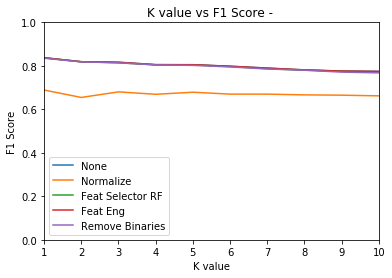

In [98]:
#create a KNN model with varying nearest neighbors as the baseline
#We chose to loop through values from 1 to 20 to assess the F1 scores the KNN algorithm


for ds in range(len(train_datasets)):
    loc1 = model_performance_df['Model Name'].notna()[::-1].idxmax()+1
    f1_2 = []
    for i in range(1,11):
        knn_model_2 = KNeighborsClassifier(n_neighbors = i)
        start_train = time.time()
        knn_model_2.fit(train_datasets[ds], train_data_label)
        end_train = time.time()
        train_time = str(round(end_train - start_train, 2))
        
        start_test = time.time()
        y_dev_pred = knn_model_2.predict(dev_datasets[ds])
        end_test = time.time()
        test_time = str(round(end_test - start_test, 2))
        knn_f1_2 = round(metrics.f1_score(dev_data_label, y_dev_pred, average='macro'),4)
        f1_2.append(knn_f1_2)
        #print("Transformation:", transformation_names[ds])
        #print("F1 score of baseline knn = " + str(knn_f1_2))
    max_f1 = max(f1_2)
    print("Transformation:", transformation_names[ds],max_f1)
    plt.plot(range(1,11), f1_2)
    plt.xlim(1,10)
    plt.ylim(0,1)
    plt.xlabel("K value")
    plt.ylabel("F1 Score")
    plt.title("K value vs F1 Score - ")#, transformation_names[ds])
    plt.legend(transformation_names)
    model_performance_df.iloc[loc1] = ['KNN', train_time, test_time, max_f1, transformation_names[ds]]
    


## Results Summary

In [99]:
model_performance_df.sort_values(by=['F1 Score'], ascending= False)[:50]

,Model Name,Train Time(s),Prediction Time(s),F1 Score,Pre-processor
14,Extra Trees,7.25,0.3,0.875,Remove Binaries
13,Extra Trees,11.52,0.3,0.874,Feat Eng
10,Extra Trees,12.03,0.3,0.873,None
11,Extra Trees,12.66,0.4,0.872,Normalize
12,Extra Trees,7.12,0.31,0.862,Feat Selector RF
9,Random Forest,2.97,0.11,0.853,Remove Binaries
5,Random Forest,2.67,0.11,0.848,None
7,Random Forest,2.81,0.11,0.848,Feat Selector RF
8,Random Forest,2.76,0.12,0.848,Feat Eng
15,Extreme Gradient Boost,22.42,0.08,0.845,None


In [102]:
#model_performance_df['Model Name'].notna()[::-1].idxmax()

34

### Confusion Matrix of best classifier

Get a Confusion Matrix for the best performing classifier, which is Extra Trees

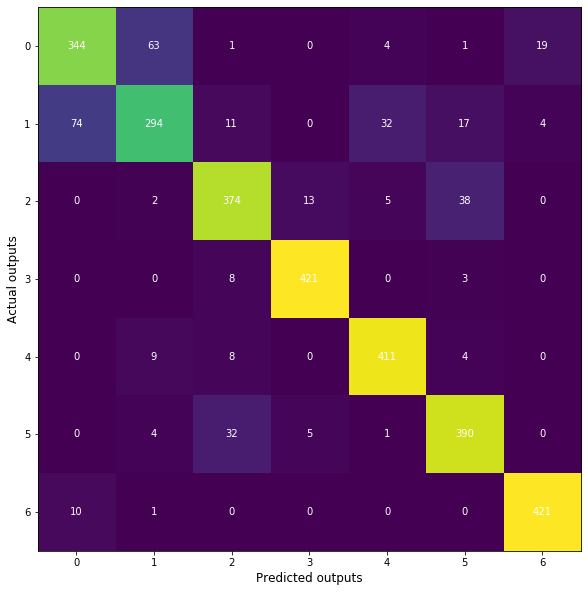

In [103]:
ExtraTree_clf = ExtraTreesClassifier(max_features=0.8, max_depth = 30, n_estimators=500)

ExtraTree_clf.fit(train_data_rem_bin, train_data_label) # Fitting the train data to the classifier   
    # Make prediction on dev data
    
pred = ExtraTree_clf.predict(dev_data_rem_bin)
    

#y_pred_prob = knn_model.predict_proba(dev_data)

        
cm = confusion_matrix(dev_data_label, pred)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=12, color='black')
ax.set_ylabel('Actual outputs', fontsize=12, color='black')
ax.xaxis.set(ticks=range(7))
ax.yaxis.set(ticks=range(7))
ax.set_ylim(6.5, -0.5)
for i in range(7):
    for j in range(7):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()



The best performing model still seems to mostly confuse 1s and 2s. We can find the best model for the dataset filtered by 1 and 2 Cover Types only, and then do an ensemble

In [117]:


# train_data_norm2 = normalize_processor(train_data2)
# train_data_rf_selector2 = rf_feature_selector(train_data2,15)
# train_data_feat_eng2 = feat_eng(train_data2)
# train_data_rem_bin2 = rem_binary(train_data2)


# dev_data_norm2 = normalize_processor(dev_data2)
# dev_data_rf_selector2 = rf_feature_selector(dev_data2,15)
# dev_data_feat_eng2 = feat_eng(dev_data2)
# dev_data_rem_bin2 = rem_binary(dev_data2)

# train_datasets2 = [train_data2,  train_data_norm2, train_data_rf_selector2,  \
#                   train_data_feat_eng2, train_data_rem_bin2]

# dev_datasets2 = [dev_data2, dev_data_norm2, dev_data_rf_selector2, \
#                 dev_data_feat_eng2, dev_data_rem_bin2]

# transformation_names2 = ["None",  "Normalize2", "Feat Selector RF2","Feat Eng2", "Remove Binaries2"]

In [108]:
RF_revised = RandomForestClassifier(min_samples_split = 2, n_estimators = 200, max_depth = 20)
#for ds in range(len(train_datasets2)):
RF_revised.fit(train_data2, train_data_label2) # Fitting the train data to the classifier 
#predict = RF_revised.predict(test_data)
RF_revised_pred = RF_revised.predict(dev_data2)
RF_revised_f1 = round(metrics.f1_score(dev_data_label2, RF_revised_pred, average='macro'),3)
# print("Transformation:", transformation_names2[ds])
print("F1 score of revised Random Forest = " + str(RF_revised_f1))

F1 score of revised Random Forest = 0.809


In [111]:
#for ds in range(len(train_datasets2)):
clf = tree.DecisionTreeClassifier(max_depth = 20)
start_train = time.time()
clf = clf.fit(train_data2, train_data_label2)
end_time = time.time()
train_time = str(round(end_time - start_train, 2))

start_test = time.time()
tree_pred= clf.predict(dev_data2)
end_test = time.time()
test_time = str(round(end_test - start_test, 2))
accuracy = round(metrics.f1_score(dev_data_label2, tree_pred, average="macro"),3)
print("F1 score of Decision Trees = " + str(accuracy))
#model_performance_df.iloc[loc1] = ['Decision Trees', train_time, test_time, accuracy, transformation_names2[ds]]
#loc1 +=1 

F1 score of Decision Trees = 0.764


In [128]:
#for ds in range(len(train_datasets)):
#loc1 = model_performance_df['Model Name'].notna()[::-1].idxmax()+1
ExtraTree_clf = ExtraTreesClassifier(max_features=0.8, max_depth = 30, n_estimators=500)

ExtraTree_clf.fit(train_data2, train_data_label2) # Fitting the train data to the classifier   
# Make prediction on dev data
log_probs_12 = ExtraTree_clf.predict_log_proba(dev_data2)


pred = ExtraTree_clf.predict(dev_data2)
print(pred[:10])
# Store metrics
dev_f1 = round(metrics.f1_score(dev_data_label2, pred, average='macro'), 3)
print("F1 score of Extra Trees = " + str(dev_f1))

# print("F1 Score for Extra Trees = " + str(dev_f1))
#model_performance_df.iloc[loc1] = ['Extra Trees', train_time, test_time, dev_f1, transformation_names2[ds]]
##We need to adjust this DF to account for all the versions, unless we just get the max one

#print("Transformation:", transformation_names2[ds], dev_f1)
   



[[-1.84938858 -0.17118381]
 [-0.614336   -0.77870507]
 [-0.00601807 -5.11599581]
 [-1.66073121 -0.21072103]
 [-3.24933503 -0.03957278]
 [-0.86750057 -0.54472718]
 [-0.02224561 -3.81671283]
 [-0.57092955 -0.83240925]
 [-1.43129173 -0.27312192]
 [-2.68824757 -0.07042246]]
[2 1 1 2 2 2 1 1 2 2]
F1 score of Extra Trees = 0.817


/Users/shalac/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:635: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


In [114]:


xgb_clf = xgb.XGBClassifier(max_depth = 10, n_estimators = 50, learning_rate = 0.1)

xgb_clf.fit(train_data2, train_data_label2) # Fitting the train data to the classifier   


pred = xgb_clf.predict(dev_data2)

# Store metrics
dev_f1 = round(metrics.f1_score(dev_data_label2, pred, average='macro'), 3)
print("F1 score of XGB = " + str(dev_f1))

    

F1 score of XGB = 0.808


F1 for KNN 0.7812


Text(0.5, 1.0, 'K value vs F1 Score - ')

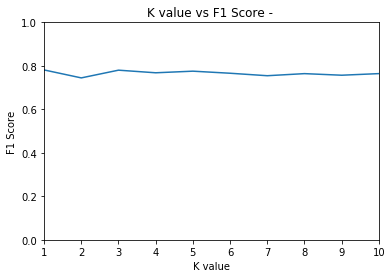

In [115]:
#for ds in range(len(train_datasets2)):
 #   loc1 = model_performance_df['Model Name'].notna()[::-1].idxmax()+1
f1_2 = []
for i in range(1,11):
    knn_model_2 = KNeighborsClassifier(n_neighbors = i)
    start_train = time.time()
    knn_model_2.fit(train_data2, train_data_label2)
    end_train = time.time()
    train_time = str(round(end_train - start_train, 2))

    start_test = time.time()
    y_dev_pred = knn_model_2.predict(dev_data2)
    end_test = time.time()
    test_time = str(round(end_test - start_test, 2))
    knn_f1_2 = round(metrics.f1_score(dev_data_label2, y_dev_pred, average='macro'),4)
    f1_2.append(knn_f1_2)
    #print("Transformation:", transformation_names[ds])
    #print("F1 score of baseline knn = " + str(knn_f1_2))
print("F1 for KNN",  max(f1_2))
plt.plot(range(1,11), f1_2)
plt.xlim(1,10)
plt.ylim(0,1)
plt.xlabel("K value")
plt.ylabel("F1 Score")
plt.title("K value vs F1 Score - ")#, transformation_names[ds])
#plt.legend(transformation_names2)
#model_performance_df.iloc[loc1] = ['KNN', train_time, test_time, dev_f1, transformation_names2[ds]]

In [126]:
lg1= LogisticRegression(C=1, solver="liblinear", multi_class="auto")
lg1.fit(train_data2, train_data_label2)
lg_pred1= lg1.predict(dev_data2)
accuracy = metrics.f1_score(dev_data_label2, lg_pred1, average="weighted")
print("F1:", accuracy)

F1: 0.7742810634834508


### Remove binaries + extra trees --> anything labeled 0 or 1 --> run again?

Build Ensemble: Extra Trees -- if label 1 or 2 then re run again and use the one of highest prob?

In [ ]:
ExtraTree_clf = ExtraTreesClassifier(max_features=0.8, max_depth = 30, n_estimators=500)

ExtraTree_clf.fit(train_data2, train_data_label2) # Fitting the train data to the classifier   
# Make prediction on dev data
log_probs_12 = ExtraTree_clf.predict_log_proba(dev_data2)


pred = ExtraTree_clf.predict(dev_data2)
print(pred[:10])
# Store metrics
dev_f1 = round(metrics.f1_score(dev_data_label2, pred, average='macro'), 3)
print("F1 score of Extra Trees = " + str(dev_f1))


In [136]:
from sklearn import model_selection
from sklearn.ensemble import AdaBoostClassifier


#kfold = model_selection.KFold(n_splits=10)
ADB_clf = AdaBoostClassifier(n_estimators=30)
model = ADB_clf.fit(train_data, train_data_label)
y_pred = model.predict(dev_data)
#score1= ADB_clf.score(pred, dev_data_label)
#print(score1)
dev_f1 = round(metrics.f1_score(dev_data_label, y_pred, average='macro'), 3)
print(dev_f1)

0.272


/Users/shalac/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
